In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
import pickle

In [2]:
emails=pd.read_csv("endava_email_tickets_ML.csv")

In [3]:
emails.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [4]:
regexList = []
regexList += ['From:(.*)\r\n']  # from line
regexList += ['^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$']
regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+']
regexList += ['Subject:']
regexList += ['[^a-zA-Z]']
emails['body'] = emails['body'].replace(regexList, ' ')

In [5]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

In [6]:
def clean_text(text):
    text = text.lower()    
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text
X_body = emails['body'].apply(lambda p: clean_text(p))

In [7]:
max_phrase_len = X_body.apply(lambda p: len(p.split(' '))).max()

In [8]:
Y_urgency = emails['urgency']

In [10]:
Y_urgency.value_counts()

3    34621
1     6748
2     5528
0     1652
Name: urgency, dtype: int64

In [9]:
max_words = 10000
tokenizer = Tokenizer(
    num_words = max_words)
tokenizer.fit_on_texts(X_body)
X = tokenizer.texts_to_sequences(X_body)
X = pad_sequences(X, maxlen = max_phrase_len)
Y = to_categorical(Y_urgency)

In [9]:
#Y

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)

In [12]:
model_lstm_urgency = Sequential()
model_lstm_urgency.add(Embedding(10000, 128, input_length = max_phrase_len))
model_lstm_urgency.add(SpatialDropout1D(0.3))
model_lstm_urgency.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm_urgency.add(Dense(4, activation = 'softmax'))
model_lstm_urgency.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

W1211 07:18:49.512362  6840 deprecation_wrapper.py:119] From C:\Users\Admin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1211 07:18:49.972304  6840 deprecation_wrapper.py:119] From C:\Users\Admin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1211 07:18:50.049767  6840 deprecation_wrapper.py:119] From C:\Users\Admin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1211 07:18:50.221243  6840 deprecation_wrapper.py:119] From C:\Users\Admin\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1211 07:18:50.257780  6840 deprecation.py:506

In [16]:
history = model_lstm_urgency.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    epochs = 2,
    batch_size = 128)

W1211 07:21:54.900184  6840 deprecation.py:323] From C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 27187 samples, validate on 6797 samples
Epoch 1/2
27187/27187 [==============================] - 3690s 136ms/step - loss: 0.4408 - acc: 0.8094 - val_loss: 0.2922 - val_acc: 0.8496
Epoch 2/2
27187/27187 [==============================] - 4022s 148ms/step - loss: 0.2923 - acc: 0.8497 - val_loss: 0.2864 - val_acc: 0.8551


In [ ]:
acc_urgency = model_lstm_urgency.fit(X_test,y_test)

Epoch 1/1
 7264/14565 [=============>................] - ETA: 37:55 - loss: 0.3094 - acc: 0.8468

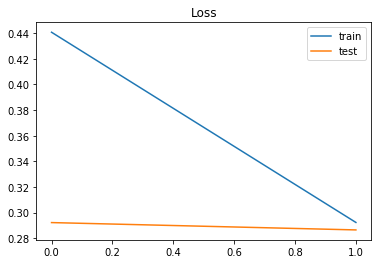

In [17]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

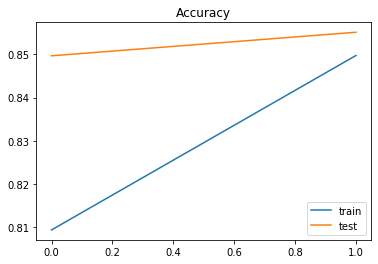

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [19]:
pickle.dump(model_lstm_urgency, open('model_urgency.pkl','wb'))

In [20]:
test=['icon dear please setup icon per icon engineers please let other details needed thanks lead']

In [21]:
test_tokens = tokenizer.texts_to_sequences(test)
test_sequence = pad_sequences(test_tokens, maxlen = max_phrase_len)

In [22]:
model = pickle.load(open('model_urgency.pkl','rb'))
print(np.argmax(model.predict(test_sequence)))

3
